This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Adjusting radar-base rainfall estimates by rain gauge observations

## Background

There are various ways to correct specific errors and artifacts in radar-based quantitative precipitation estimates (*radar QPE*). Alternatively, you might want to correct your radar QPE regardless of the error source - by using ground truth, or, more specifically, rain gauge observations. Basically, you define the error of your radar QPE at a rain gauge location by the discrepancy between rain gauge observation (considered as "the truth") and radar QPE at that very location. Whether you consider this "discrepancy" as an *additive* or *multiplicative* error is somehow arbitrary - typically, it's a *mix* of both. If you quantify this error at various locations (i.e. rain gauges), you can go ahead and construct correction fields for your radar QPE. You might compute a single correction factor for your entire radar domain (which would e.g. make sense in case of hardware miscalibration), or you might want to compute a spatially variable correction field. This typically implies to interpolate the error in space.

$\omega radlib$ provides different error models and different spatial interpolation methods to address the adjustment problem. For details, please refer to $\omega radlib's$ [library reference](https://docs.wradlib.org/en/latest/adjust.html).

In [1]:
import wradlib.adjust as adjust
import wradlib.verify as verify
import wradlib.util as util
import numpy as np
import matplotlib.pyplot as pl

try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

## Example for the 1-dimensional case

Looking at the 1-D (instead of 2-D) case is more illustrative.

### Create synthetic data

First, we **create synthetic data**: 
- true rainfall, 
- point observations of the truth, 
- radar observations of the truth.

The latter is disturbed by some kind of error, e.g. a combination between systemtic and random error.

In [2]:
# gage and radar coordinates
obs_coords = np.array([5, 10, 15, 20, 30, 45, 65, 70, 77, 90])
radar_coords = np.arange(0, 101)

# true rainfall
truth = np.abs(1.5 + np.sin(0.075 * radar_coords)) + np.random.uniform(
    -0.1, 0.1, len(radar_coords))

# radar error
erroradd = 0.7 * np.sin(0.2 * radar_coords + 10.)
errormult = 0.75 + 0.015 * radar_coords
noise = np.random.uniform(-0.05, 0.05, len(radar_coords))

# radar observation
radar = errormult * truth + erroradd + noise

# gage observations are assumed to be perfect
obs = truth[obs_coords]

# add a missing value to observations (just for testing)
obs[1] = np.nan

### Apply different adjustment methods

- additive error, spatially variable (`AdjustAdd`)
- multiplicative error, spatially variable (`AdjustMultiply`)
- mixed error, spatially variable (`AdjustMixed`)
- multiplicative error, spatially uniform (`AdjustMFB`)

In [3]:
# number of neighbours to be used
nnear_raws = 3

# adjust the radar observation by additive model
add_adjuster = adjust.AdjustAdd(obs_coords, radar_coords,
                                nnear_raws=nnear_raws)
add_adjusted = add_adjuster(obs, radar)

# adjust the radar observation by multiplicative model
mult_adjuster = adjust.AdjustMultiply(obs_coords, radar_coords,
                                      nnear_raws=nnear_raws)
mult_adjusted = mult_adjuster(obs, radar)

# adjust the radar observation by AdjustMixed
mixed_adjuster = adjust.AdjustMixed(obs_coords, radar_coords,
                                    nnear_raws=nnear_raws)
mixed_adjusted = mixed_adjuster(obs, radar)

# adjust the radar observation by MFB
mfb_adjuster = adjust.AdjustMFB(obs_coords, radar_coords,
                                nnear_raws=nnear_raws, 
                                mfb_args = dict(method="median"))
mfb_adjusted = mfb_adjuster(obs, radar)

/opt/conda/envs/wradlib/lib/python3.7/site-packages/wradlib/ipol.py:368: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0 / self.dists ** self.p
/opt/conda/envs/wradlib/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


### Plot adjustment results

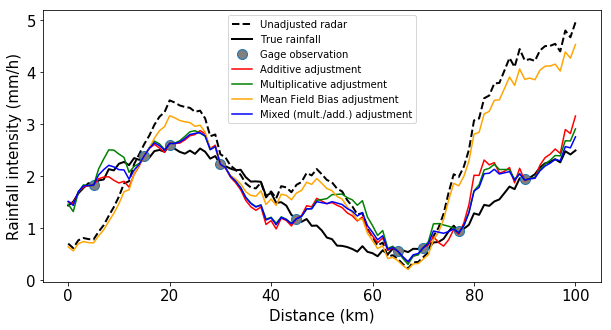

In [4]:
# Enlarge all label fonts
font = {'size'   : 15}
pl.rc('font', **font)

pl.figure(figsize=(10,5))
pl.plot(radar_coords, radar,         'k-', linewidth=2., linestyle="dashed", label="Unadjusted radar", )
pl.plot(radar_coords, truth,         'k-', linewidth=2., label="True rainfall", )
pl.plot(obs_coords,   obs,           'o',  markersize=10.0, markerfacecolor="grey", label="Gage observation")
pl.plot(radar_coords, add_adjusted,  '-',  color="red",   label="Additive adjustment")
pl.plot(radar_coords, mult_adjusted, '-',  color="green", label="Multiplicative adjustment")
pl.plot(radar_coords, mfb_adjusted,  '-',  color="orange", label="Mean Field Bias adjustment")
pl.plot(radar_coords, mixed_adjusted,'-',  color="blue", label="Mixed (mult./add.) adjustment")
pl.xlabel("Distance (km)")
pl.ylabel("Rainfall intensity (mm/h)")
leg = pl.legend(prop={'size': 10})

### Verification

We use the `verify` module to compare the errors of different adjustment approaches.

*Here, we compare the adjustment to the "truth". In practice, we would carry out a cross validation.*

In [5]:
# Verification for this example
rawerror = verify.ErrorMetrics(truth, radar)
mfberror = verify.ErrorMetrics(truth, mfb_adjusted)
adderror = verify.ErrorMetrics(truth, add_adjusted)
multerror = verify.ErrorMetrics(truth, mult_adjusted)
mixerror = verify.ErrorMetrics(truth, mixed_adjusted)

In [6]:
# Helper function for scatter plot
def scatterplot(x, y, title=""):
    """Quick and dirty helper function to produce scatter plots
    """
    pl.scatter(x, y)
    pl.plot([0, 1.2 * maxval], [0, 1.2 * maxval], '-', color='grey')
    pl.xlabel("True rainfall (mm)")
    pl.ylabel("Estimated rainfall (mm)")
    pl.xlim(0, maxval + 0.1 * maxval)
    pl.ylim(0, maxval + 0.1 * maxval)
    pl.title(title)

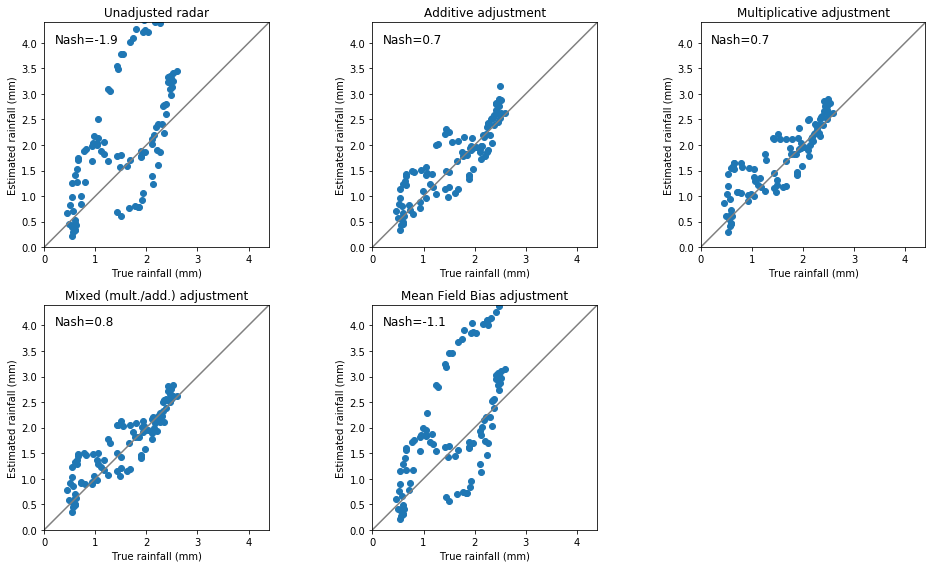

In [7]:
# Verification reports
maxval = 4.
# Enlarge all label fonts
font = {'size'   : 10}
pl.rc('font', **font)
fig = pl.figure(figsize=(14, 8))
ax = fig.add_subplot(231, aspect=1.)
scatterplot(rawerror.obs, rawerror.est, title="Unadjusted radar")
ax.text(0.2, maxval, "Nash=%.1f" % rawerror.nash(), fontsize=12)
ax = fig.add_subplot(232, aspect=1.)
scatterplot(adderror.obs, adderror.est, title="Additive adjustment")
ax.text(0.2, maxval, "Nash=%.1f" % adderror.nash(), fontsize=12)
ax = fig.add_subplot(233, aspect=1.)
scatterplot(multerror.obs, multerror.est, title="Multiplicative adjustment")
ax.text(0.2, maxval, "Nash=%.1f" % multerror.nash(), fontsize=12)
ax = fig.add_subplot(234, aspect=1.)
scatterplot(mixerror.obs, mixerror.est, title="Mixed (mult./add.) adjustment")
ax.text(0.2, maxval, "Nash=%.1f" % mixerror.nash(), fontsize=12)
ax = fig.add_subplot(235, aspect=1.)
scatterplot(mfberror.obs, mfberror.est, title="Mean Field Bias adjustment")
ax.text(0.2, maxval, "Nash=%.1f" % mfberror.nash(), fontsize=12)
pl.tight_layout()

## Example for the 2-dimensional case

For the 2-D case, we follow the same approach as before:

- create synthetic data: truth, rain gauge observations, radar-based rainfall estimates
- apply adjustment methods
- verification

The way these synthetic data are created is totally arbitrary - it's just to show how the methods are applied.

### Create 2-D synthetic data

In [8]:
# grid axes
xgrid = np.arange(0, 10)
ygrid = np.arange(20, 30)

# number of observations
num_obs = 10

# create grid
gridshape = len(xgrid), len(ygrid)
grid_coords = util.gridaspoints(ygrid, xgrid)

# Synthetic true rainfall
truth = np.abs(10. * np.sin(0.1 * grid_coords).sum(axis=1))

# Creating radar data by perturbing truth with multiplicative and
# additive error
# YOU CAN EXPERIMENT WITH THE ERROR STRUCTURE
radar = 0.6 * truth + 1. * np.random.uniform(low=-1., high=1,
                                             size=len(truth))
radar[radar < 0.] = 0.

# indices for creating obs from raw (random placement of gauges)
obs_ix = np.random.uniform(low=0, high=len(grid_coords),
                           size=num_obs).astype('i4')

# creating obs_coordinates
obs_coords = grid_coords[obs_ix]

# creating gauge observations from truth
obs = truth[obs_ix]

### Apply different adjustment methods

In [9]:
# Mean Field Bias Adjustment
mfbadjuster = adjust.AdjustMFB(obs_coords, grid_coords)
mfbadjusted = mfbadjuster(obs, radar)

# Additive Error Model
addadjuster = adjust.AdjustAdd(obs_coords, grid_coords)
addadjusted = addadjuster(obs, radar)

# Multiplicative Error Model
multadjuster = adjust.AdjustMultiply(obs_coords, grid_coords)
multadjusted = multadjuster(obs, radar)

/opt/conda/envs/wradlib/lib/python3.7/site-packages/wradlib/adjust.py:628: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, _, _, _ = np.linalg.lstsq(x, y)


### Plot 2-D adjustment results

In [10]:
# Helper functions for grid plots
def gridplot(data, title):
    """Quick and dirty helper function to produce a grid plot
    """
    xplot = np.append(xgrid, xgrid[-1] + 1.) - 0.5
    yplot = np.append(ygrid, ygrid[-1] + 1.) - 0.5
    grd = ax.pcolormesh(xplot, yplot, data.reshape(gridshape), vmin=0,
                        vmax=maxval)
    ax.scatter(obs_coords[:, 0], obs_coords[:, 1], c=obs.ravel(),
               marker='s', s=50, vmin=0, vmax=maxval)
    #pl.colorbar(grd, shrink=0.5)
    pl.title(title)

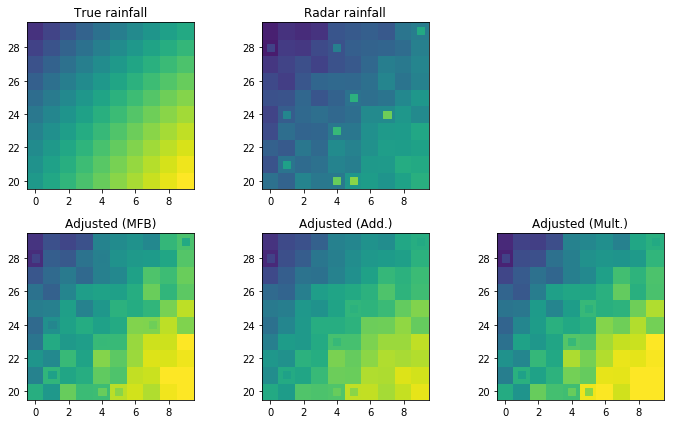

In [11]:
# Maximum value (used for normalisation of colorscales)
maxval = np.max(np.concatenate((truth, radar, obs, addadjusted)).ravel())

# open figure
fig = pl.figure(figsize=(10, 6))

# True rainfall
ax = fig.add_subplot(231, aspect='equal')
gridplot(truth, 'True rainfall')

# Unadjusted radar rainfall
ax = fig.add_subplot(232, aspect='equal')
gridplot(radar, 'Radar rainfall')

# Adjusted radar rainfall (MFB)
ax = fig.add_subplot(234, aspect='equal')
gridplot(mfbadjusted, 'Adjusted (MFB)')

# Adjusted radar rainfall (additive)
ax = fig.add_subplot(235, aspect='equal')
gridplot(addadjusted, 'Adjusted (Add.)')

# Adjusted radar rainfall (multiplicative)
ax = fig.add_subplot(236, aspect='equal')
gridplot(multadjusted, 'Adjusted (Mult.)')

pl.tight_layout()

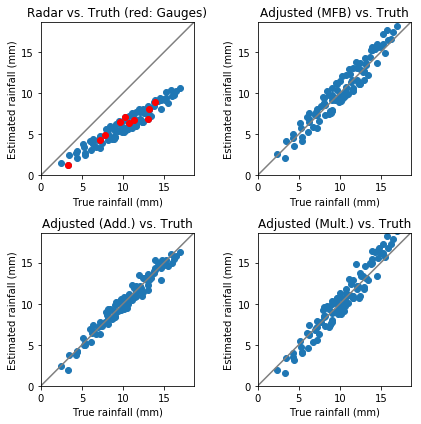

In [12]:
# Open figure
fig = pl.figure(figsize=(6, 6))

# Scatter plot radar vs. observations
ax = fig.add_subplot(221, aspect='equal')
scatterplot(truth, radar, 'Radar vs. Truth (red: Gauges)')
pl.plot(obs, radar[obs_ix], linestyle="None", marker="o", color="red")

# Adjusted (MFB) vs. radar (for control purposes)
ax = fig.add_subplot(222, aspect='equal')
scatterplot(truth, mfbadjusted, 'Adjusted (MFB) vs. Truth')

# Adjusted (Add) vs. radar (for control purposes)
ax = fig.add_subplot(223, aspect='equal')
scatterplot(truth, addadjusted, 'Adjusted (Add.) vs. Truth')

# Adjusted (Mult.) vs. radar (for control purposes)
ax = fig.add_subplot(224, aspect='equal')
scatterplot(truth, multadjusted, 'Adjusted (Mult.) vs. Truth')

pl.tight_layout()